# Imports

In [322]:
%matplotlib inline
from pybedtools import BedTool
from pybedtools.featurefuncs import midpoint
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Functions

In [323]:
def read_cpg_islands(filepath):
    def line_to_dict(line):
        values = line.split()
        return f'{values[1]} {values[2]} {values[3]}'
    with open(filepath, 'r') as f:
        content = f.readlines()
    return keep_autosomal_chromosomes(
        BedTool('\n'.join([line_to_dict(l) for l in content]), from_string=True))

def keep_autosomal_chromosomes(records):
    autosomal_chromosomes = [f'chr{ind}' for ind in range(1, 23)]
    return BedTool([record for record in records
                if record[0] in autosomal_chromosomes])

# Task 1

In [324]:
cpg_islands = read_cpg_islands('./cpgIslandExt.txt')
genome_sizes = BedTool('./hg19.chrom.sizes')

In [325]:
shore_flank_size = 2000
shelf_flank_size = 2000

In [326]:
shores = cpg_islands.flank(genome='hg19', b=shore_flank_size)

In [327]:
# prevent cpg island overlap
shores = shores.subtract(cpg_islands)

In [328]:
shelves = shores.flank(genome='hg19', b=shelf_flank_size).subtract(shores).subtract(cpg_islands)

In [329]:
combined_beds = BedTool(list(shores) + list(shelves) + list(cpg_islands))

In [330]:
seas = combined_beds.sort().complement(genome='hg19')

## Save results

In [331]:
for bed, filename in zip([cpg_islands, shores, shelves, seas], ['cpg.bed', 'shores.bed', 'shelves.bed', 'seas.bed']):
    bed.saveas(filename)

# Task 2

In [332]:
methylations_data = BedTool('./wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz')
autosomal_methylations_data = keep_autosomal_chromosomes(methylations_data)
autosomal_methylations_data = BedTool([midpoint(m) for m in autosomal_methylations_data])

# Task 3

In [333]:
def get_hits(chromosome_ranges, metylations):
    return len(metylations.intersect(chromosome_ranges, u=True))

In [334]:
hit_counts = {name: get_hits(bed, autosomal_methylations_data) 
        for bed, name in zip([cpg_islands, shores, shelves, seas], ['cpg', 'shores', 'shelves', 'seas'])}
    
sorted_hits = dict(sorted(hit_counts.items(), key=lambda kv: kv[1]))

In [335]:
counts = sum(hit_counts.values())
percentages = {area: hit_counts[area] / counts for area in sorted_hits}

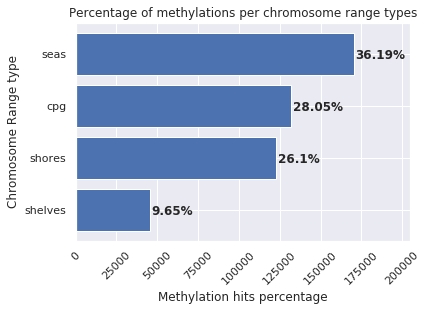

In [336]:
fib, ax = plt.subplots()
ax.barh(list(sorted_hits.keys()), sorted_hits.values())
ax.set_xlabel('Methylation hits percentage')
ax.set_ylabel('Chromosome Range type')
ax.set_title('Percentage of methylations per chromosome range types')
ax.set_xlim(0, 205000)
plt.xticks(rotation=45)

for i, v in enumerate(sorted_hits.values()):
    ax.text(v + 1000, i - 0.1, f'{round(100 * list(percentages.values())[i], 2)}%', fontweight='bold')